In [1]:
from prophet import Prophet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot

In [3]:
# Read a pandas DataFrame
df = pd.read_csv('group_samples/data_weekly_from2017.csv',
                 parse_dates=True)

In [4]:
df.head()

,DATETIME,WORKINGGROUP,INPUT_FORMAT_SHORT,INPUT_FORMAT_DESC,INPUT_PROJECT,N_TASKS,N_FILES
0,2017-02-19,NaN,HITS,NaN,mc15_13TeV,31,80
1,2017-01-15,phys-higgs,DAOD,HIGGD,mc15_13TeV,167,1467
2,2017-02-12,NaN,DAOD,SUSY,mc15_13TeV,7517,10013
3,2017-02-12,NaN,AOD,NaN,mc15_13TeV,837,1704
4,2021-06-06,NaN,AOD,NaN,mc16_13TeV,113,272


In [5]:
df['INPUT_FORMAT_DESC'].fillna('-',inplace=True)

In [7]:
higgs = df[(df['INPUT_FORMAT_DESC'].str.contains('HIGG')) &
(df['INPUT_FORMAT_SHORT'] == 'DAOD') &
(df['INPUT_PROJECT'] == 'mc16_13TeV')][['DATETIME','N_TASKS']]

In [8]:
higgs = higgs.groupby('DATETIME')['N_TASKS'].sum()

In [9]:
higgs = pd.DataFrame(higgs)

In [10]:
higgs.index = pd.to_datetime(higgs.index)

In [11]:
higgs['logNTasks'] = np.log(higgs['N_TASKS']).copy()

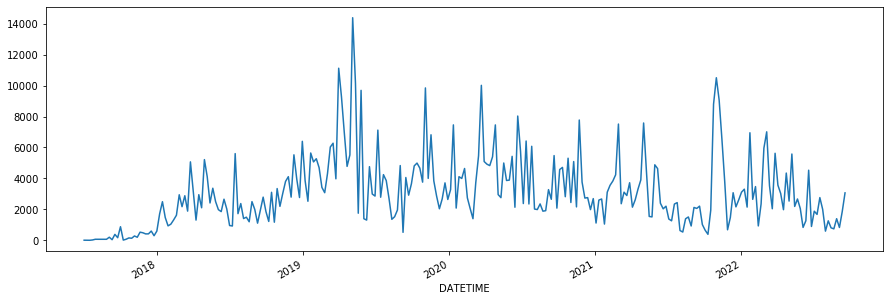

In [12]:
higgs['N_TASKS'].plot(figsize=(15,5));

In [13]:
higgs.head()

,N_TASKS,logNTasks
DATETIME,,
2017-07-02,6,1.791759
2017-07-16,2,0.693147
2017-07-23,21,3.044522
2017-07-30,66,4.189655
2017-08-20,65,4.174387


In [14]:
df_p = higgs[['logNTasks']].copy()

In [15]:
df_p

,logNTasks
DATETIME,
2017-07-02,1.791759
2017-07-16,0.693147
2017-07-23,3.044522
2017-07-30,4.189655
2017-08-20,4.174387
...,...
2022-08-21,6.605298
2022-08-28,7.241366
2022-09-04,6.720220


In [16]:
# cut df_p from 2018
df_p = df_p[df_p.index >= '2018-01-01']

In [17]:
df_p.columns = ['y']

In [18]:
df_p['ds'] = df_p.index

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_p

,y,ds
DATETIME,,
2018-01-07,7.446585,2018-01-07
2018-01-14,7.822044,2018-01-14
2018-01-21,7.294377,2018-01-21
2018-01-28,6.838405,2018-01-28
2018-02-04,6.948897,2018-02-04
...,...,...
2022-08-21,6.605298,2022-08-21
2022-08-28,7.241366,2022-08-28
2022-09-04,6.720220,2022-09-04


In [20]:
# Define threshold date.
Ntest = 12
df_train = df_p.iloc[:-Ntest]
df_test = df_p.iloc[-Ntest:]

In [21]:
df_train.shape

(234, 2)

In [22]:
df_test.shape

(12, 2)

In [27]:
events_df = pd.read_csv('hep_events.csv',sep=';')

In [28]:
events_df['ds'] = pd.to_datetime(events_df['ds'])

In [29]:
events_df.drop('Unnamed: 4', axis=1, inplace=True)

In [30]:
events_df[events_df.isna().any(axis=1)]
events_df.dropna(inplace=True)

In [31]:
events_df[['ds','holiday']].tail(10)

,ds,holiday
257,2017-05-03,La Thuile
258,2017-06-03,CTD
259,2017-06-03,FCAL
260,2017-06-03,CLIC
261,2017-02-27,INSTR17
262,2017-02-20,Trento
263,2017-02-19,LLWI
264,2017-01-24,BTTB
265,2017-01-23,CPIX17
266,2017-09-01,Epiphany


In [32]:
summer_vacations = pd.DataFrame({'holiday': "Summer Vacations",
                      'ds' : pd.to_datetime(['2018-08-01',
                                             '2019-08-01',
                                             '2020-08-01',
                                             '2021-08-01',
                                             '2022-08-01']),
                      'lower_window': 0,
                      'upper_window': 10})
winter_vacations = pd.DataFrame({'holiday': "Winter Vacations",
                      'ds' : pd.to_datetime(['2017-12-24',
                                             '2018-12-24',
                                             '2019-12-24',
                                             '2020-12-24',
                                             '2021-12-24',
                                             '2022-12-24']),
                      'lower_window': 0,
                      'upper_window': 10})
events = pd.concat([events_df,summer_vacations,winter_vacations])

In [33]:
from prophet.make_holidays import make_holidays_df
#
year_list = [2019, 2020, 2021, 2022]
countries = ['US','CN']
holidays = [make_holidays_df(year_list=year_list, country=i) for i in countries]
type(holidays)

list

In [34]:
holidays_df = pd.concat(holidays)
holidays_df

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-01-21,Martin Luther King Jr. Day
2,2019-02-18,Washington's Birthday
3,2019-05-27,Memorial Day
4,2019-07-04,Independence Day
...,...,...
39,2022-04-05,Tomb-Sweeping Day
40,2022-06-03,Dragon Boat Festival
41,2022-09-10,Mid-Autumn Festival
42,2022-10-03,National Day


In [35]:
all_events = pd.concat((holidays_df,events_df[['ds','holiday']]))

In [36]:
m = Prophet(yearly_seasonality=True,
            holidays=events_df,
            changepoint_prior_scale=0.05)
            #holidays_prior_scale=1)

In [37]:
#m.add_country_holidays('US')

In [38]:
m.fit(df_train)

13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future = m.make_future_dataframe(periods=df_test.shape[0], freq='W')

In [40]:
forecast = m.predict(future)

In [41]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,(REMOTE ONLY),(REMOTE ONLY)_lower,(REMOTE ONLY)_upper,--- VIRTUAL,...,yearly,yearly_lower,yearly_upper,ÖPG 2018,ÖPG 2018_lower,ÖPG 2018_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-07,7.554002,7.048370,8.148353,7.554002,7.554002,0.0,0.0,0.0,0.0,...,0.052193,0.052193,0.052193,0.0,0.0,0.0,0.0,0.0,0.0,7.606195
1,2018-01-14,7.563005,7.290514,8.304174,7.563005,7.563005,0.0,0.0,0.0,0.0,...,0.181423,0.181423,0.181423,0.0,0.0,0.0,0.0,0.0,0.0,7.797349
2,2018-01-21,7.572008,6.737481,7.832977,7.572008,7.572008,0.0,0.0,0.0,0.0,...,0.186898,0.186898,0.186898,0.0,0.0,0.0,0.0,0.0,0.0,7.290367
3,2018-01-28,7.581011,7.115979,8.154896,7.581011,7.581011,0.0,0.0,0.0,0.0,...,0.038615,0.038615,0.038615,0.0,0.0,0.0,0.0,0.0,0.0,7.619626
4,2018-02-04,7.590015,6.408730,7.495897,7.590015,7.590015,0.0,0.0,0.0,0.0,...,-0.117709,-0.117709,-0.117709,0.0,0.0,0.0,0.0,0.0,0.0,6.944460


/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


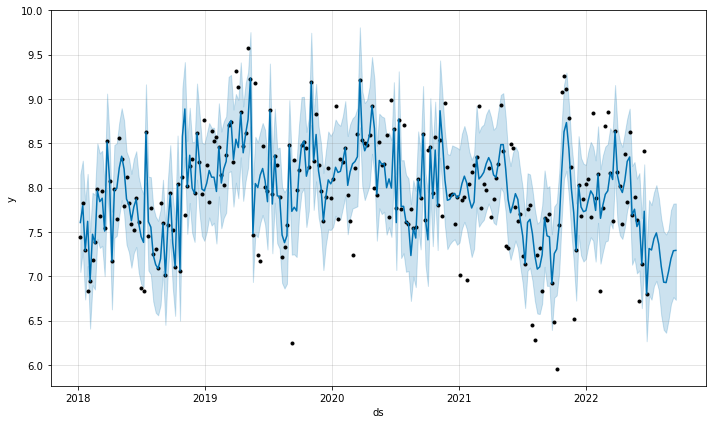

In [42]:
m.plot(forecast);

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_

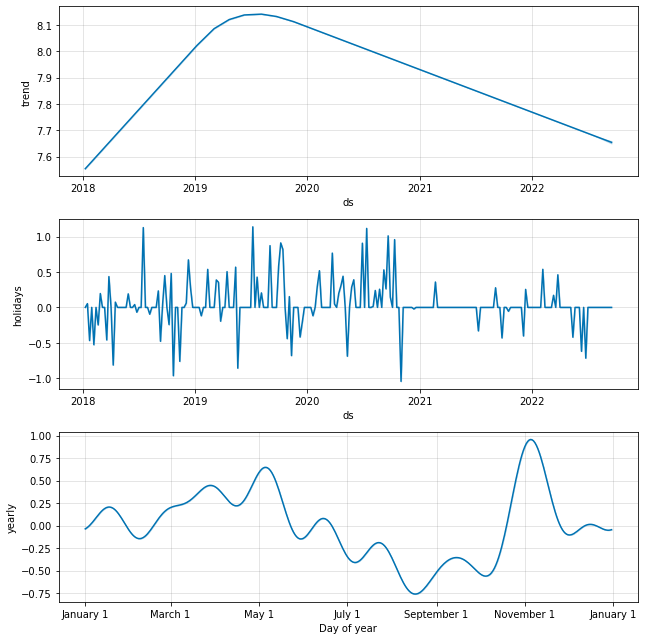

In [43]:
m.plot_components(forecast);


In [44]:
forecast['y'] = df_p['y'].tolist()

In [45]:
forecast.set_index('ds',inplace=True)

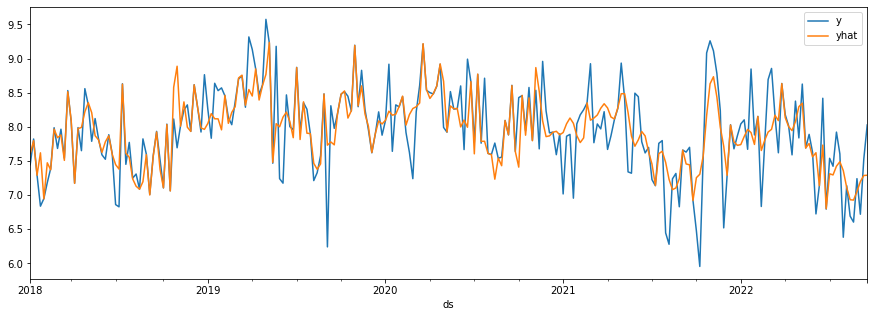

In [46]:
forecast[['y','yhat']].plot(figsize=(15,5));

In [47]:
forecast['Y'] = np.exp(forecast['y'])
forecast['Yhat'] = np.exp(forecast['yhat'])

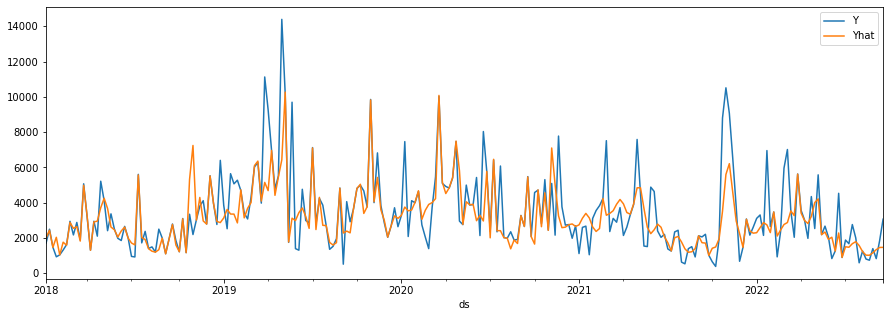

In [48]:
forecast[['Y','Yhat']].plot(figsize=(15,5));

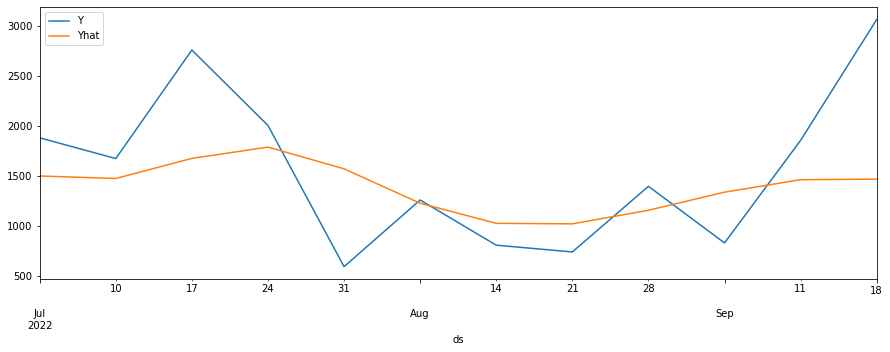

In [49]:
forecast[['Y','Yhat']][-df_test.shape[0]:].plot(figsize=(15,5));

In [50]:
from sklearn.metrics import mean_absolute_percentage_error
# MAPE
# test_log_loss = higgs.iloc[-Ntest:]['logNTasks']
forecast.reset_index(inplace=True)
real = forecast.loc[-df_test.shape[0]:,'y'].tolist()
pred = forecast.loc[-df_test.shape[0]:,'yhat'].tolist()
mape = mean_absolute_percentage_error(real,pred)
print("MAPE:", mape)

MAPE: 0.03445068547949879


In [51]:
real = forecast.loc[-df_test.shape[0]:,'Y'].tolist()
pred = forecast.loc[-df_test.shape[0]:,'Yhat'].tolist()
mape = mean_absolute_percentage_error(real,pred)
print("MAPE:", mape)

MAPE: 0.3046769218056793


In [52]:
forecast.reset_index(inplace=True)

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_

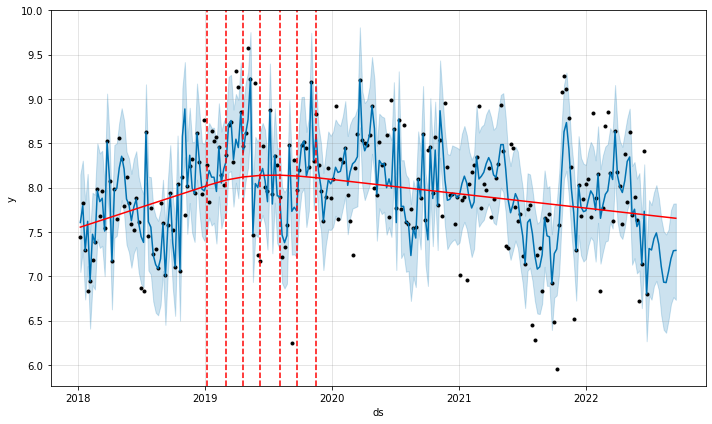

In [53]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [54]:
from prophet.diagnostics import cross_validation

In [55]:
df_cv = cross_validation(
    m,
    initial='700 days',
    period='50 days',
    horizon='100 days'
)

  0%|          | 0/17 [00:00<?, ?it/s]

13:25:13 - cmdstanpy - INFO - Chain [1] start processing
13:25:14 - cmdstanpy - INFO - Chain [1] done processing
13:25:15 - cmdstanpy - INFO - Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
13:25:17 - cmdstanpy - INFO - Chain [1] start processing
13:25:17 - cmdstanpy - INFO - Chain [1] done processing
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:22 - cmdstanpy - INFO - Chain [1] done processing
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:24 - cmdstanpy - INFO - Chain [1] done processing
13:25:26 - cmdstanpy - INFO - Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:31 - cmdstanpy - INFO - Chain [1]

In [56]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-01-12,8.072383,7.722452,8.445334,8.917445,2020-01-08
1,2020-01-19,8.576013,8.222144,8.934406,7.641564,2020-01-08
2,2020-01-26,8.124729,7.775520,8.451906,8.321665,2020-01-08
3,2020-02-02,8.232792,7.899508,8.594436,8.293299,2020-01-08
4,2020-02-09,8.197634,7.856929,8.568690,8.442901,2020-01-08
...,...,...,...,...,...,...
238,2022-05-29,7.669861,7.140354,8.175097,7.629004,2022-03-18
239,2022-06-05,7.738730,7.155776,8.261126,6.725034,2022-03-18
240,2022-06-12,7.789268,7.246996,8.292758,7.142037,2022-03-18
241,2022-06-19,7.663320,7.205490,8.223133,8.418698,2022-03-18


In [57]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [58]:
pm = performance_metrics(df_cv)
pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,0.445007,0.667089,0.571094,0.069497,0.059176,0.070930,0.375000
1,11 days,0.472497,0.687384,0.575416,0.071185,0.059176,0.071746,0.416667
2,12 days,0.560913,0.748941,0.625543,0.076390,0.064941,0.077466,0.402778
3,13 days,0.557555,0.746696,0.627734,0.076633,0.064941,0.078005,0.416667
4,14 days,0.531573,0.729091,0.591968,0.072499,0.064941,0.073703,0.444444
...,...,...,...,...,...,...,...,...
86,96 days,0.685435,0.827910,0.627899,0.082716,0.048425,0.080456,0.541667
87,97 days,0.690303,0.830845,0.638663,0.084408,0.051880,0.082069,0.541667
88,98 days,0.635394,0.797116,0.600999,0.080337,0.051880,0.077822,0.555556
89,99 days,0.637856,0.798659,0.604829,0.081273,0.051880,0.079024,0.541667


In [59]:
pm['smape'].mean()

0.06997710893350563

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/maria/opt/miniconda3

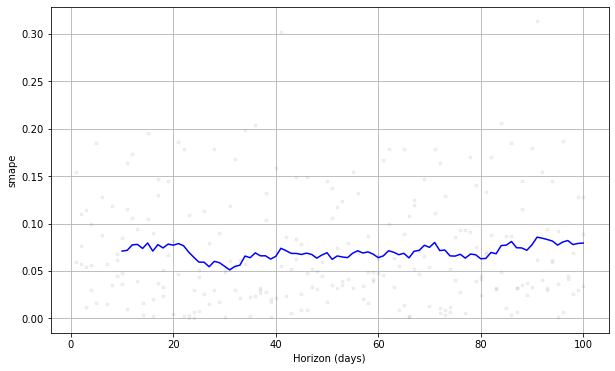

In [60]:
plot_cross_validation_metric(df_cv, metric='smape');


